# 가짜연구소 4기 - 추천시스템 톺아보기
## MAB(Multi-Armed Bandint) & Thompson sampling을 활용한 추천
- 작성자: 김민수(kimminsu.ds@gmail.com)
- 데이터 출처: 

## 00. 환경설정

### 00-01. 패키지

In [1]:
import random
import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib import pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
from scipy.stats import beta

import warnings
warnings.filterwarnings("ignore")

### 00-02. Avazu ctr prediction 데이터

In [3]:
parse_date = lambda x: datetime.strptime(x, '%y%m%d%H')
ad_df = pd.read_csv("../data/mab_ad_click.csv", parse_dates = ['datetime'], date_parser = parse_date, header=0)
ad_df.head()

,id,click,datetime,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10010804179216291475,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,-1,79
1,10013076841337920650,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15702,320,50,1722,0,35,-1,79
2,100156980486870304,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
3,10036789730923212176,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15703,320,50,1722,0,35,-1,79
4,10050938058905541797,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15707,320,50,1722,0,35,-1,79


### 00-03. 데이터 살펴보기
- MAB 문제에서 자주 사용되는 데이터(광고 노출/클릭 데이터)
- 주어진 Context에서 어떤 광고를 보여줄지 선택하는 것을 Policy
- 특정 광고를 보여주는 것이 action에 해당하고 노출 이후에 클릭이 일어나면 **`reward=1`** 그렇지 않다면 **`reward=0`**

#### C14 컬럼이 광고의 소재 ID

In [4]:
ad_df.apply(lambda x: len(x.unique())).sort_values(ascending=False)

id                  160297
device_ip            64217
device_model          1026
C14                    362
datetime               240
C20                     93
C17                     88
C21                     32
C19                     32
C18                      4
device_conn_type         2
C15                      2
C16                      2
click                    2
device_type              1
app_category             1
app_domain               1
app_id                   1
site_category            1
site_domain              1
site_id                  1
banner_pos               1
C1                       1
device_id                1
dtype: int64

#### 광고 노출 시간과 광고 소재의 ID를 활용

In [5]:
mab_df = ad_df[['id', 'C14', 'datetime', 'click']]
mab_df = mab_df.rename(columns={'C14': 'ad'}, inplace=False)
mab_df

,id,ad,datetime,click
0,10010804179216291475,15704,2014-10-21 00:00:00,0
1,10013076841337920650,15702,2014-10-21 00:00:00,0
2,100156980486870304,15706,2014-10-21 00:00:00,0
3,10036789730923212176,15703,2014-10-21 00:00:00,1
4,10050938058905541797,15707,2014-10-21 00:00:00,1
...,...,...,...,...
160292,9899837143248831576,22257,2014-10-30 23:00:00,1
160293,9905100583305466044,15706,2014-10-30 23:00:00,0
160294,9962540383484110617,22261,2014-10-30 23:00:00,0
160295,9964318073950212472,22676,2014-10-30 23:00:00,0


- 노출 가능한 광고는 362개

In [6]:
mab_df['ad'].nunique()

362

In [7]:
mab_df['ad'].head()

0    15704
1    15702
2    15706
3    15703
4    15707
Name: ad, dtype: int64

#### 광고별 평균 CTR(Y)

In [9]:
ad_statistics = pd.DataFrame({
    'imp'   : mab_df.groupby('ad')['id'].nunique(),
    'click' : mab_df.groupby('ad')['click'].sum(),
    'ctr'   : mab_df.groupby('ad')['click'].mean()    
}).reset_index()

ad_statistics.head()

,ad,imp,click,ctr
0,6616,637,76,0.119309
1,8330,579,80,0.138169
2,9248,1,0,0.000000
3,9436,4,0,0.000000
4,9438,6,0,0.000000


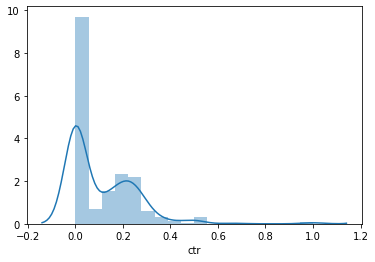

In [11]:
sns.distplot(ad_statistics['ctr'])
plt.show()

#### 노출 수가 너무 적은 ad의 경우 Policy에 대한 신뢰도가 낮음
- 데이터가 아주 적을 때 Bandit이 exploration을 해주긴 하지만 실제 추천을 수행할 때는 너무 적은 데이터가 쌓인 아이템은 policy를 사용하지 않음

In [12]:
ad_statistics.sort_values(by='ctr', ascending=False)[:20]

,ad,imp,click,ctr
303,23222,1,1,1.000000
24,18496,1,1,1.000000
139,22288,3,2,0.666667
250,23015,2,1,0.500000
209,22818,2,1,0.500000
308,23445,2,1,0.500000
154,22745,2,1,0.500000
251,23016,2,1,0.500000
175,22774,4,2,0.500000
276,23153,11,5,0.454545


## 01. MAB을 활용한 추천시스템 구현

### 01-01. Offline evaluation
- 기존 추천시스템의 경우 데이터를 train/test로 나누어 모델 구축 후 test 데이터로 성능 평가
- MAB의 경우 전체 데이터를 시간 순서대로 정렬한 뒤 batch 단위로 policy를 업데이트 후 다음 batch에서 policy를 평가

#### 평가 방식
1. 시간 순서대로 정렬된 데이터를 N개 단위의 batch로 분할
2. 각 batch마다 현재 policy에 맞는 아이템을 추천
3. 추천된 결과와 해당 결과의 실제 reward를 비교하여 cumulative rewards를 업데이트
    - 추천된 아이템과 실제 노출된 아이템이 같지 않다면 cumulative rewards를 업데이트 하지 않음
    - 추천된 아이템과 실제 노출된 아이템이 같다면 cumulative rewards를 업데이트
4. cumulative rewards를 업데이트 후 해당 batch의 데이터를 가지고 policy를 업데이트
5. 다음 batch에서 2~4를 반복 수행

#### 광고 노출/클릭 데이터를 시간 순서대로 정렬

In [13]:
mab_df = mab_df.sort_values(by='datetime')
mab_df['imp'] = 1
mab_df

,id,ad,datetime,click,imp
0,10010804179216291475,15704,2014-10-21 00:00:00,0,1
696,4251691006404076570,15707,2014-10-21 00:00:00,0,1
697,4256548079061461216,15704,2014-10-21 00:00:00,0,1
698,4256814970000693395,15705,2014-10-21 00:00:00,0,1
699,4272263715071891030,15699,2014-10-21 00:00:00,0,1
...,...,...,...,...,...
160025,15638333441364131220,22257,2014-10-30 23:00:00,0,1
160024,15612835964008476367,22254,2014-10-30 23:00:00,0,1
160023,15599245444302734215,15705,2014-10-30 23:00:00,0,1
160033,15977258595711361825,22676,2014-10-30 23:00:00,0,1


#### Random policy
- 매번 랜덤하게 아이템을 선택해 추천하는 random policy를 baseline으로 설정

In [60]:
ad_list = mab_df['ad'].unique().tolist()
recommend_size = 5
batch_size = 500
rewards = []
reward_timelines_random = []

In [61]:
for t in tqdm(range(mab_df.shape[0] // batch_size)):
    t = t * batch_size
    
    # 랜덤하게 아이템을 선택하여 추천
    recs = np.random.choice(ad_list, size=(recommend_size), replace=False)
    
    # 현재 batch의 데이터를 가져옵니다.
    batch_df = mab_df[t:t+batch_size]
    
    # 추천된 아이템과 일치하는 데이터에 대해서 cumulative reward를 구합니다.
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines_random.append(np.mean(rewards))
        
print("number of offline sample:", len(rewards))
print("expected reward:", np.mean(rewards))


number of offline sample: 2117
expected reward: 0.2026452527161077


In [62]:
recs

array([23169, 23016, 23153, 22886, 23015])

In [63]:
rewards_random = np.mean(rewards)

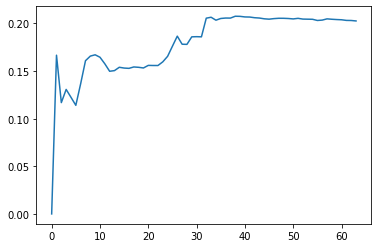

In [64]:
plt.plot(reward_timelines_random)
plt.show()

### 01-02. Epsilon greedy
- epsilon(e)의 확률로 랜덤하게 아이템 선택
- (1 - e)의 확률로 가장 CTR이 높았던 아이템을 선택하여 추천
- 충분한 데이터가 확보되지 않은 아이템의 경우 greedy algorithm에서 제외

In [65]:
class eGreedy :
    def __init__(self):
        self.mean = 0
        self.N = 0
        
    def update(self, reward):
        self.N += 1
        self.mean = (1 - 1.0 / self.N) * self.mean + 1.0 / self.N * reward

In [66]:
policy_dict = {ad : eGreedy() for ad in ad_list}
recommend_size = 5
batch_size = 500
epsilon = 0.1
rewards = []
reward_timelines_epsilon = []

for t in tqdm(range(mab_df.shape[0] // batch_size + 1)):
    
    t = t * batch_size
    
    # epsilon의 확률로 0과 1 가운데 하나를 뽑습니다.
    explore = np.random.binomial(1, epsilon)
    
    if explore == 1:
        # 랜덤하게 아이템을 선택하여 추천
        recs = np.random.choice(ad_list, size=(recommend_size), replace=False).tolist()
        
    else:
        # 광고별 평균 CTR을 가져옵니다. 
        # 이 때 지금까지 수집된 데이터가 10개 이상인 것만 추출합니다.
        candidates = [(ad, egreedy.mean) for ad, egreedy in policy_dict.items() if egreedy.N >= 10]
        
        # 평균 ctr 순서대로 가장 높은 아이템을 추천합니다.
        candidates = sorted(candidates, key=lambda x: (x[1]), reverse=True)[:recommend_size]
        recs = [ad for ad, ctr in candidates]
        
        # 추천 아이템이 recommend_size보다 작은 경우에는 랜덤하게 나머지를 샘플링합니다.
        if len(recs) < recommend_size:
            additional_recs = list(set(ad_list) - set(recs))
            additional_recs = np.random.choice(additional_recs, size=(recommend_size-len(recs)), replace=False).tolist()
            recs.extend(additional_recs)
            
        
    # Policy를 업데이트합니다.
    batch_df = mab_df[t:t+batch_size]
    
    for _, row in batch_df.iterrows():
        policy_dict[row['ad']].update(row['click'])
        
    # policy를 평가합니다.
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines_epsilon.append(np.mean(rewards))
        
print("number of offline sample:", len(rewards))
print("expected reward:", np.mean(rewards))


number of offline sample: 13123
expected reward: 0.22563438238207728


In [67]:
rewards_epsilon = np.mean(rewards)

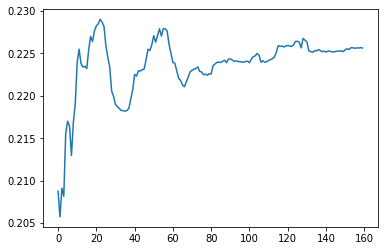

In [68]:
plt.plot(reward_timelines_epsilon)
plt.show()

### 01-03. UCB(Upper Confidence Bound)

In [69]:
class UCB:
    def __init__(self, c):
        self.mean = 0
        self.N = 0
        self.c = c
        
    def update(self, reward):
        self.N += 1
        self.mean = (1 - 1.0 / self.N) * self.mean + 1.0 / self.N * reward
        
    def score(self, t):
        return self.mean + self.c * np.sqrt(np.log(t+1) / self.N)

In [70]:
c = 0.2
policy_dict = {ad : UCB(c) for ad in ad_list}
recommend_size = 5
batch_size = 500
rewards = []
reward_timelines_ucb = []

for t in tqdm(range(mab_df.shape[0] // batch_size + 1)):
    t = t * batch_size
    
    # 개별 광고에 대해 각각 UCB 스코어 값을 구합니다.
    candidates = [(ad, ucb.score(t)) for ad, ucb in policy_dict.items() if ucb.N >= 10]
    
    # ucb 스코어 순서대로 가장 높은 아이템을 추천합니다.
    candidates = sorted(candidates, key=lambda x: (x[1]), reverse=True)[:recommend_size]
    recs = [ad for ad, score in candidates]
    
    # 추천 아이템이 recommend_size보다 작은 경우에는 랜덤하게 나머지를 샘플링합니다.
    if len(recs) < recommend_size:
        additional_recs = list(set(ad_list) - set(recs))
        additional_recs = np.random.choice(additional_recs, size=(recommend_size-len(recs)), replace=False).tolist()
        recs.extend(additional_recs)
        
    # Policy를 업데이트합니다.
    batch_df = mab_df[t:t+batch_size]
    
    for _, row in batch_df.iterrows():
        policy_dict[row['ad']].update(row['click'])
        
    # Policy를 평가합니다.
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines_ucb.append(np.mean(rewards))
        
print("number of offline sample:", len(rewards))
print("expected reward:", np.mean(rewards))


number of offline sample: 11542
expected reward: 0.21997920637671114


In [71]:
rewards_ucb = np.mean(rewards)

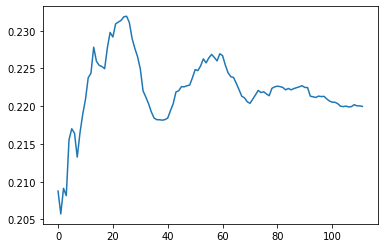

In [72]:
plt.plot(reward_timelines_ucb)
plt.show()

### 01-04. Thompson sampling

In [73]:
from scipy.stats import beta

class TS:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.N = 0
        
    def update(self, reward):
        self.N += 1
        if reward > 0:
            self.a += 1
        else:
            self.b += 1
            
    def sample(self):
        return beta.rvs(self.a, b + self.b, size=1)[0]

In [74]:
a = 2; b = 8
policy_dict = {ad: TS(a, b) for ad in ad_list}
recommend_size = 5
batch_size = 500
rewards = []
reward_timelines_ts = []

for t in tqdm(range(mab_df.shape[0] // batch_size+1)):
    t = t * batch_size
    
    # 개별 광고에 대해서 beta 분포 샘플링을 통해 얻어진 score 값을 구해옵니다.
    candidates = [(ad, ts.sample()) for ad, ts in policy_dict.items() if ts.N >= 10]
    
    # score 순서대로 가장 높은 아이템을 추천합니다.
    candidates = sorted(candidates, key=lambda x: (x[1]), reverse=True)[:recommend_size]
    recs = [ad for ad, score in candidates]
    
    # 추천 아이템이 recommend_size보다 작은 경우에는 랜덤하게 나머지를 샘플링합니다.
    if len(recs) < recommend_size:
        additional_recs = list(set(ad_list) - set(recs))
        additional_recs = np.random.choice(additional_recs, size=(recommend_size-len(recs)), replace=False).tolist()
        recs.extend(additional_recs)
        
    # Policy를 업데이트합니다.
    batch_df = mab_df[t : t + batch_size]
    for _, row in batch_df.iterrows():
        policy_dict[row['ad']].update(row['click'])
        
    # Policy를 평가합니다.
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines_ts.append(np.mean(rewards))
        
print("number of offline sample:", len(rewards))
print("expected reward:", np.mean(rewards))


number of offline sample: 25512
expected reward: 0.23412511759172155


In [79]:
rewards_ts = np.mean(rewards)

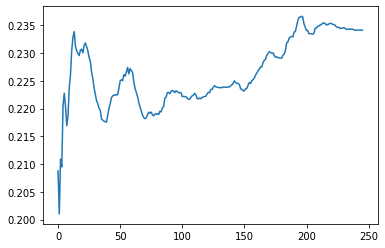

In [75]:
plt.plot(reward_timelines_ts)
plt.show()

#### 01-05. 모델병 성능 비교

In [80]:
print("Random: {:.3f}".format(rewards_random))
print("Epsilon greedy: {:.3f}".format(rewards_epsilon))
print("UCB: {:.3f}".format(rewards_ucb))
print("Thompson sampling: {:.3f}".format(rewards_ts))

Random: 0.203
Epsilon greedy: 0.226
UCB: 0.220
Thompson sampling: 0.234


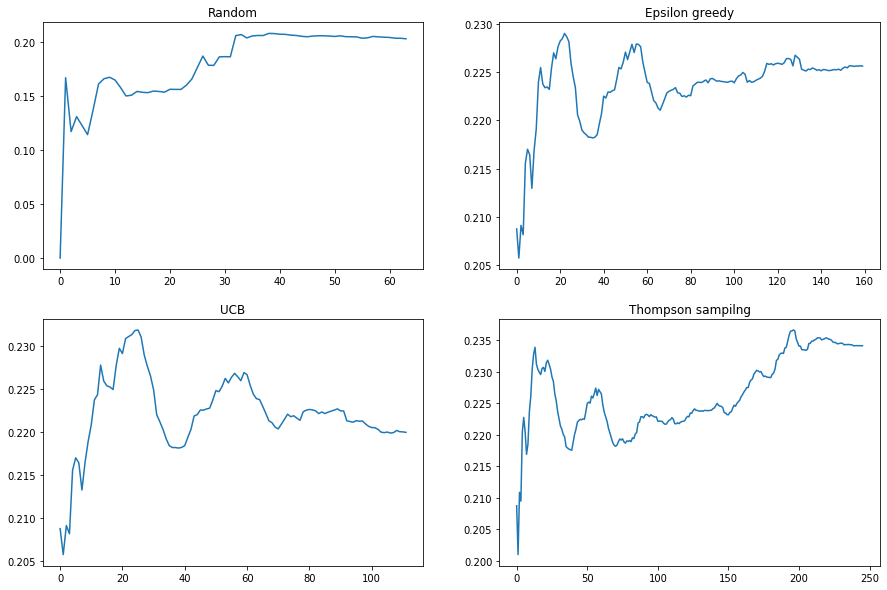

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0][0].plot(reward_timelines_random)
axes[0][0].set_title("Random")

axes[0][1].plot(reward_timelines_epsilon)
axes[0][1].set_title("Epsilon greedy")

axes[1][0].plot(reward_timelines_ucb)
axes[1][0].set_title("UCB")

axes[1][1].plot(reward_timelines_ts)
axes[1][1].set_title("Thompson sampilng")

plt.show()